In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B2: Ablation

> predict + ersatz (shuffle/dinucleotide shuffle) + predict

In the context of evaluating sequence features, the conceptual opposite of a marginalization experiment is an ablation experiment. A marginalization experiment involves holding fixed a short sequence of interest, such as a protein binding site, but having variable background sequence everywhere else. In contrast, an ablation experiment involves shuffling given coordinates while keeping everything else fixed. Put another way: a marginalization experiment usually involves adding a potentially informative feature to uninformative sequence, whereas an ablation experiment involves removes a potentially informative feature from informative sequence.

A common use-case of an ablation experiment is to systematically remove regions of interest to evaluate their marginal and joint effects. For example, in the genomics setting, one may systematically remove all individual protein binding sites from an enhancer or promoter of interest and evaluate how the predictions change. As a more sophisticated example, one might try deleting each of the parts of a composite fusion motif, where multiple motifs are merged together in non-canonical ways, to better understand each component.

#### Ablate

Ablations can be done in `tangermeme` using the `ablate` function. Much like the other functions, `ablate` takes in a predictive model, one or more sequences, and coordinates to shuffle. Since there are multiple ways that one could shuffle a set of given coordinates, e.g. uniformly random shuffling, replacing with randomly generated sequence, dinucleotide shuffling, etc., `ablate` allows the user to optionally pass in a shuffling function. 

Likewise similar to other functions, `ablate` returns the predictions on the original sequences and on all `n` shuffles of the given coordinates. This means that if `y_before.shape == (5, 1)` because the model yields one value for each of five examples, then `y_after.shape == (5, n, 1)` where `n` is the number of shuffles to do on the specified regions. It is up to the user to determine the best way to take these predictions and yield a single score.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

Let's construct a region that the model will respond to by generating some random sequence and then inserting an AP-1 motif into it. 

In [3]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

X = random_one_hot((100, 4, 2000)).type(torch.float32)  # Generate 100 random sequences to marginalize over
X = substitute(X, "GTGACTCATC")

Now, we can look at the predictions from the model before and after shuffling the middle of the examples -- where the motif has been inserted.

In [4]:
from tangermeme.ablate import ablate

y_before, y_after = ablate(model, X, 995, 1005, device='cpu')
y_before.shape, y_after.shape

(torch.Size([100, 2002]), torch.Size([100, 20, 2002]))

Note that `y_after` has an additional dimension when compared with `y_before`. As mentioned before, this is because the shuffling is done `n` times (default 20) and predictions are returned for each shuffle. For simplicity, we can just take the average across the 20 runs.

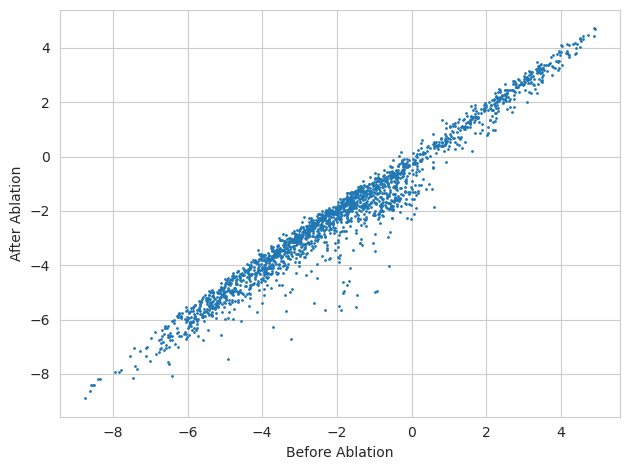

In [5]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')


plt.scatter(y_before.mean(axis=0).numpy(force=True), y_after.mean(axis=(0, 1)).numpy(force=True), s=1)
plt.xlabel("Before Ablation")
plt.ylabel("After Ablation")
plt.tight_layout()
plt.show()

As one might expect, it looks like the majority of tasks are unaffected by the ablation of the AP-1 motif from the sequence. But we can rank tasks by those that are most effected to see which ones they are.

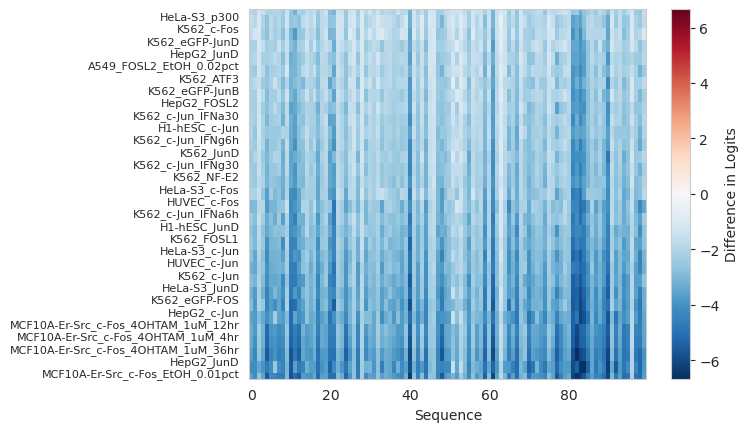

In [6]:
import numpy

names = numpy.array([name[:40].replace("_None", "") for name in numpy.loadtxt("beluga_target_names.txt", delimiter=',', dtype=str)])

y_delta = y_after.mean(axis=1) - y_before
idxs = torch.argsort(y_delta.mean(axis=0))
ymax = max(abs(y_delta.min()), abs(y_delta.max()))


plt.imshow(y_delta[:, idxs].T, aspect='auto', cmap='RdBu_r', vmin=-ymax, vmax=ymax, interpolation='nearest')
plt.colorbar(label="Difference in Logits")
plt.ylim(0, 30)
plt.yticks(numpy.arange(0.5, 30.5, 1), names[idxs[:30]], fontsize=8)
plt.xlabel("Sequence")
plt.grid(False)
plt.show()

It seems like those most effected by the ablation of the AP-1 motif are tasks related to the AP-1 factors (c-/Jun, c-/Fos, JunD, etc..). 

To continue with this trend of results being the opposite of what one might expect from marginalizations, let's load up a BPNet GATA2 model and see what happens to model predictions before and after removing the GATA motif from a genomic sequence.

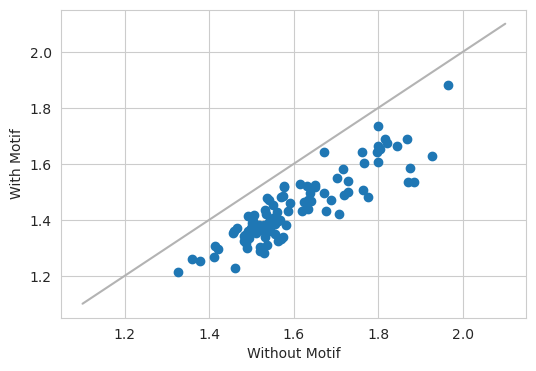

In [7]:
bpnet = torch.load("gata2.bpnet.torch")

X = random_one_hot((100, 4, 2114)).type(torch.float32)  # Generate 100 random sequences with the right size for BPNet to marginalize over
X = substitute(X, "CTTATCT")

y_before, y_after = ablate(bpnet, X, 1052, 1062, args=(torch.zeros(100, 2, 2114),), device='cpu')

plt.figure(figsize=(6, 4))
plt.scatter(y_before[1], y_after[1].mean(axis=1))
plt.plot([1.1, 2.1], [1.1, 2.1], color='0.7')
plt.xlabel("Without Motif")
plt.ylabel("With Motif")
plt.show()

As expected, the model predicts a lower value after ablating out the motif.

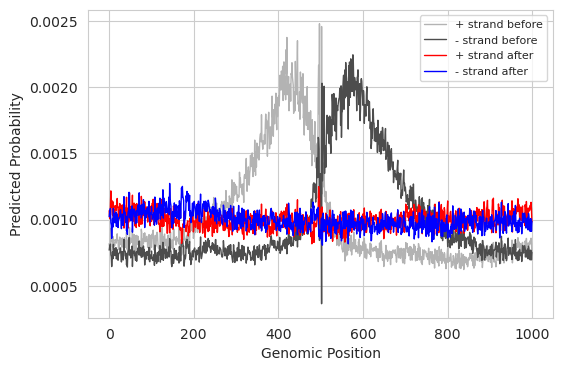

In [8]:
yb = torch.nn.functional.softmax(y_before[0].mean(axis=0), dim=-1)
ya = torch.nn.functional.softmax(y_after[0].mean(axis=(0, 1)), dim=-1)

plt.figure(figsize=(6, 4))
plt.plot(yb[0], color='0.7', linewidth=1, label="+ strand before")
plt.plot(yb[1], color='0.3', linewidth=1, label="- strand before")

plt.plot(ya[0], color='r', linewidth=1, label="+ strand after")
plt.plot(ya[1], color='b', linewidth=1, label="- strand after")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")
plt.legend(fontsize=8)
plt.show()

Likewise, we can see the inverse pattern here from the marginalization experiment. Before ablating, the profile predictions show clear bimodal peaks in the profile predictions. After ablating, the model is predicting largely flat signal.

A note for all of these ablation experiments (the DeepSEA and the BPNet ones) is that, although they do seem to show exactly the opposite results as the marginalization experiments, this is because we are not using the ablation function in the setting it is most likely to be used in practice. Basically, here, we are constructing synthetic background sequences, inserting a motif in, and then ablating it out. In practice, one is going to take a real region of the genome and ablate out one or more motifs instead of focusing on the individual effect of one motif isolated from the others. 